 # Strategy Selection for All Stocks

In [21]:
import datetime
import pandas as pd
import numpy as np
import os
from typing import Tuple, List, Callable
from abc import abstractmethod
import yfinance as yf
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.feature_selection import mutual_info_classif, RFE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import scipy.optimize as sco
import warnings
import matplotlib.pyplot as plt
from typing_extensions import override

warnings.filterwarnings("ignore")

In [22]:
# Some paths to store data and trading logs
DATA_PATH = 'Data'
PREDICTION_PATH = 'Predictions'
PORTFOLIO_VALUES_PATH = 'PortfolioValues'

# List of stocks to analyze
TICKERS = ['AMZN', 'BA', 'CAT', 'GOOGL', 'GS', 'NKE', 'NVDA', 'SOFI', 'TSLA', 'UNH']


## Abstract Class for Trading Strategy

In [23]:
# Define the strategy parameters, add additional parameters as needed
class StrategyParams:
    '''
    This is a data class representing the parameters used for the strategies.
    '''
    def __init__(self, train_start_date: str, train_end_date: str, test_start_date: str, test_end_date: str):
        self.train_start_date = train_start_date
        self.train_end_date = train_end_date
        self.test_start_date = test_start_date
        self.test_end_date = test_end_date


In [24]:
class TradingStrategy:
    '''
    This is an abstract class representing the interface of a trading strategy.
    '''

    @abstractmethod
    def run_strategy(self, data: pd.DataFrame, ticker: str, params: StrategyParams) -> pd.DataFrame:
        """
        Abstract method to run the trading strategy.
        """
        pass

 ## Strategy 1: RSI

In [25]:
class RsiStrategy(TradingStrategy):
    '''
    This class encapsulates the logic to trade with RSI strategy.
    '''

    # Function to compute RSI for a given series and window
    def compute_RSI(self, series, window):
        delta = series.diff()
        gain = delta.clip(lower=0)
        loss = -delta.clip(upper=0)
        avg_gain = gain.rolling(window=window, min_periods=window).mean()
        avg_loss = loss.rolling(window=window, min_periods=window).mean()
        RS = avg_gain / (avg_loss + 1e-10)  # Avoid division by zero
        RSI = 100 - (100 / (1 + RS))
        return RSI

    # Function to build the RSI strategy with long and short positions
    def rsi_strategy(self, df, window, params, oversold=30, overbought=80):
        df['RSI'] = self.compute_RSI(df['Close'], window)

        # Generate trading signals: +1 for long, -0.5 for short
        df['Signal'] = 0
        df['Signal'] = df['Signal'].astype(float)
        df.loc[df['RSI'] < oversold, 'Signal'] = 1  # Long
        df.loc[df['RSI'] > overbought, 'Signal'] = -0.5  # Short (Modified from -1 to -0.5)

        # Carry forward the last signal until a new signal appears
        df['pos'] = df['Signal'].replace(to_replace=0, method='ffill').fillna(0)

        # Calculate daily returns and strategy returns
        df['Returns'] = df['Close'].pct_change()
        df['Strategy_Returns'] = df['pos'].shift(1) * df['Returns']
        df['Strategy_Returns'].fillna(0, inplace=True)

        # Compute cumulative returns
        test_df = df.loc[params.test_start_date:params.test_end_date].copy()
        test_df['Cumulative_Return_Strategy'] = (1 + test_df['Strategy_Returns']).cumprod()
        total_return = test_df['Cumulative_Return_Strategy'].iloc[-1]

        return total_return, test_df

    # Function to perform grid search over RSI windows
    def find_best_rsi_window(self, df, window_range, params):
        results = {}
        for window in window_range:
            total_return, _ = self.rsi_strategy(df, window, params)
            results[window] = total_return
        best_window = max(results, key=results.get)
        _, best_strategy_df = self.rsi_strategy(df, best_window, params)
        return best_window, results, best_strategy_df

    @override
    def run_strategy(self, data, ticker, params):
        # Use your existing grid search functions
        data = data.loc[params.train_start_date:params.test_end_date].copy()

        window_range = range(5, 61, 3)
        best_window, results, best_strategy_df = self.find_best_rsi_window(data, window_range, params)
        # Calculate total (net) return: subtract 1 to get a percentage gain/loss
        total_return = best_strategy_df['Cumulative_Return_Strategy'].iloc[-1] - 1
        return best_strategy_df

 ## Strategy 2 : Linear Regression

Some helper functions for Strategy 2 and 3.

In [26]:
def create_lags(df: pd.DataFrame, col: str, n_lags: int):
    '''
    Generate lagged features for a specified column
    '''
    lagged_cols = []

    for lag in range(1, 1 + n_lags):
        df[f'Lag_{lag}_{col}'] = df[col].shift(lag)
        lagged_cols.append(f'Lag_{lag}_{col}')

    return lagged_cols

def scale_columns(df, window:int=10, inplace:bool = False):
    # Scale columns with large/values
    cols_to_scale = ['Close', 'High', 'Low', 'Open', 'Volume']

    if not inplace:
        df = df.copy()

    # Apply rolling standard scaling for each column
    for col in cols_to_scale:
        rolling_mean = df[col].rolling(window=window).mean().shift(1)
        rolling_std = df[col].rolling(window=window).std().shift(1)
        df[f'{col}_scaled'] = (df[col] - rolling_mean) / rolling_std

    for col in cols_to_scale:
        df[col] = df[f'{col}_scaled']
        df.drop(columns=[f'{col}_scaled'], inplace=True)

    return df.dropna()

def preprocess_data(df, inplace=False):
    if not inplace:
        df = df.copy()

    df['Returns'] = np.log(df['Close'] / df['Close'].shift(1))
    create_lags(df, 'Returns', 5)
    df = df.dropna()
    df['Directions'] = np.sign(df['Returns']).astype(int)

    # Here the target variables are the next day's values
    df['Target'] = df['Directions'].shift(-1)
    df['Target_Returns'] = df['Returns'].shift(-1)

    df = df.dropna()
    df = scale_columns(df, 10)
    return df

def stock_train_test_split(df, params) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    feature_cols = ['Close', 'High', 'Low', 'Open', 'Volume', 'Returns', 'Lag_1_Returns', 'Lag_2_Returns',
           'Lag_3_Returns', 'Lag_4_Returns', 'Lag_5_Returns']
    train_data = df.loc[params.train_start_date:params.train_end_date].copy()
    test_data = df.loc[params.test_start_date:params.test_end_date].copy()
    return train_data[feature_cols], test_data[feature_cols], train_data[['Target', 'Target_Returns']] , test_data[['Target', 'Target_Returns']]

In [27]:
class LinearRegressionTradingStrategy(TradingStrategy):
    def fit_and_predict_models(self, ticker, X_train, X_test, y_train, y_test, save_to=None):
        '''
        This class encapsulates the logic to trade with the linear regression model.
        '''
        df_result = pd.DataFrame() if not save_to else save_to

        model = LinearRegression()
        model.fit(X_train, y_train['Target'])
        y_test[f'pos'] = model.predict(X_test)
        y_test[f'pos'] = np.sign(y_test[f'pos'])
        y_test[f'pos'] = np.where(y_test[f'pos'] < -0.5, -0.5, y_test[f'pos'])
        df_result[f'pos'] = y_test['pos']
        df_result[f'ret'] = y_test[f'pos'] * y_test['Target_Returns']
        df_result[f'Cumulative_Return_Strategy'] = np.exp(df_result[f'ret'].cumsum())

        # Compute benchmark cumulative returns
        benchmark_ret = y_test['Target_Returns']
        df_result['cum_ret_benchmark'] = np.exp(benchmark_ret.cumsum())

        # As the target variables that we defined above are the next day's values, we need to revert it back
        df_result.index = y_test.index
        return df_result

    @override
    def run_strategy(self, data, ticker, params):
        data = data.loc[params.train_start_date:params.test_end_date].copy()
        preprocessed_data = preprocess_data(data)
        if 'Stock Splits' in preprocessed_data.columns:
            preprocessed_data = preprocessed_data.drop(columns=['Stock Splits'])

        X_train, X_test, y_train, y_test = stock_train_test_split(preprocessed_data, params)
        df_result = self.fit_and_predict_models(ticker=ticker, X_train=X_train, X_test=X_test,
                                           y_train=y_train, y_test=y_test)

        # Switch back to raw closes.
        df_result['Close'] = data['Close'].loc[df_result.index]
        return df_result

## Strategy 3: Random Forest

In [28]:
class RandomForestTradingStrategy(TradingStrategy):
    '''
    This class encapsulates the logic to trade with the random forest model.
    '''
    def fit_and_predict_models(self, ticker, X_train, X_test, y_train, y_test, save_to=None):
        df_result = pd.DataFrame() if not save_to else save_to
        seed = 12345
        model = RandomForestClassifier(n_estimators=250, random_state=seed)
        model.fit(X_train, y_train['Target'])
        y_test[f'pos'] = model.predict(X_test)
        y_test[f'pos'] = np.sign(y_test[f'pos'])
        y_test[f'pos'] = np.where(y_test[f'pos'] < -0.5, -0.5, y_test[f'pos'])
        df_result[f'pos'] = y_test['pos']
        df_result[f'ret'] = y_test[f'pos'] * y_test['Target_Returns']
        df_result[f'Cumulative_Return_Strategy'] = np.exp(df_result[f'ret'].cumsum())

        # Compute benchmark cumulative returns
        benchmark_ret = y_test['Target_Returns']
        df_result['cum_ret_benchmark'] = np.exp(benchmark_ret.cumsum())

        # As the target variables that we defined above are the next day's values, we need to revert it back
        df_result.index = y_test.index
        return df_result

    @override
    def run_strategy(self, data, ticker, params):
        data = data.loc[params.train_start_date:params.test_end_date].copy()
        preprocessed_data = preprocess_data(data)
        if 'Stock Splits' in preprocessed_data.columns:
            preprocessed_data = preprocessed_data.drop(columns=['Stock Splits'])

        X_train, X_test, y_train, y_test = stock_train_test_split(preprocessed_data, params)
        df_result = self.fit_and_predict_models(ticker=ticker, X_train=X_train, X_test=X_test,
                                           y_train=y_train, y_test=y_test)

        # Switch back to raw closes.
        df_result['Close'] = data['Close'].loc[df_result.index]
        return df_result

 ## Strategy 4: Logistic Regression

Some helper functions shared by Strategy 4 and 5.

In [29]:
def calculate_moving_averages(data):
    sma10 = data['Close'].shift(1).rolling(window = 10).mean()
    sma50 = data['Close'].shift(1).rolling(window = 50).mean()
    ema20 = data['Close'].shift(1).ewm(span = 20, adjust = False).mean()
    return sma10, sma50, ema20

def calculate_bb(data):
    rolling_mean = data['Close'].shift(1).rolling(window = 20).mean()
    rolling_std = data['Close'].shift(1).rolling(window = 20).std()
    boll_upper = rolling_mean + (2 * rolling_std)
    boll_lower = rolling_mean - (2 * rolling_std)
    return boll_upper, boll_lower

def calculate_macd(data):
    macd = data['Close'].shift(1).ewm(span = 12, adjust = False).mean() - data['Close'].shift(1).ewm(span = 26, adjust = False).mean()
    macd_signal = macd.ewm(span = 9, adjust = False).mean()
    return macd, macd_signal

def momentum_oscillator(data):
    stoch_k = ((data['Close'].shift(1) - data['Low'].shift(1).rolling(window = 14).min()) /
                   (data['High'].shift(1).rolling(window = 14).max() - data['Low'].shift(1).rolling(window = 14).min())) * 100

    williams_R = ((data['High'].shift(1).rolling(window = 14).max() - data['Close'].shift(1)) /
                       (data['High'].shift(1).rolling(window = 14).max() - data['Low'].shift(1).rolling(window = 14).min())) * -100
    return stoch_k, williams_R

def volume_indicators(data):
    # On-balance Volume (OBV)
    obv = (np.sign(data['Close'].shift(1).diff()) * data['Volume'].shift(1)).fillna(0).cumsum()

    # VWAP (Volume Weighted Average Price)
    vwap = (data['Close'].shift(1) * data['Volume'].shift(1)).cumsum() / data['Volume'].shift(1).cumsum()
    return (obv, vwap)

def directional_movement(data):
    dm_plus = np.where((data['High'].shift(1) - data['High'].shift(2)) > (data['Low'].shift(2) - data['Low'].shift(1)),
                           np.maximum(data['High'].shift(1) - data['High'].shift(2), 0), 0)
    dm_minus = np.where((data['Low'].shift(3) - data['Low'].shift(1)) > (data['High'].shift(1) - data['High'].shift(2)),
                            np.maximum(data['Low'].shift(2) - data['Low'].shift(1), 0), 0)
    return dm_plus, dm_minus

In [30]:
class LogisticRegressionTradingStrategy(TradingStrategy):
    '''
    This class encapsulates the logic to trade with the logistic regression model.
    '''
    def feature_selection(self, data, ticker, params: StrategyParams):
        stock_config = {
            'NKE': {'top_k': 7, 'random_state': 42},
        }
        default_config = {'top_k': 9, 'random_state': 2}

        config = stock_config.get(ticker, default_config)

        features = data.columns[7:]
        train_data = data[params.train_start_date:params.train_end_date].copy()
        X = train_data[features]
        y = train_data['direction']

        # Mutual Information
        mi_scores = mutual_info_classif(X, y, discrete_features=False, random_state=config['random_state'])
        mi_selected = pd.Series(mi_scores, index=features).nlargest(config['top_k']).index.tolist()

        # RFE
        rf = RandomForestClassifier(n_estimators=100, random_state=config['random_state'])
        rfe = RFE(rf, n_features_to_select=config['top_k'])
        rfe.fit(X, y)
        rfe_selected = X.columns[rfe.support_].tolist()

        return list(set(mi_selected) | set(rfe_selected))

    @override
    def run_strategy(self, data: pd.DataFrame, ticker: str, params: StrategyParams) -> pd.DataFrame:
        train_data = data.loc[params.train_start_date:params.train_end_date].copy()
        test_data = data.loc[params.test_start_date:params.test_end_date].copy()
        df2 = train_data[['Close', 'High', 'Low', 'Open', 'Volume']].copy()
        df3 = test_data[['Close', 'High', 'Low', 'Open', 'Volume']].copy()

        # Combine all data
        df = pd.concat((df2, df3))
        df['Returns'] = np.log(df['Close'] / df['Close'].shift(1))
        df['direction'] = (df['Returns'] > 0).astype(int)
        df['direction'] = np.where(df['direction'] == 0, -1, df['direction'])
        df.dropna(inplace=True)

        df['SMA_10'], df['SMA_50'], df['EMA_20'] = calculate_moving_averages(df)
        df['boll_upper'], df['boll_lower'] = calculate_bb(df)
        df['MACD'], df['MACD_signal'] = calculate_macd(df)
        df['stoch_k'], df['williams_R'] = momentum_oscillator(df)
        df['OBV'], df['VWAP'] = volume_indicators(df)

        for lag in range(1, 6):
            df[f'lag_{lag}'] = df['Returns'].shift(lag)

        df['day_of_week'] = df.index.dayofweek
        df['month'] = df.index.month
        df.dropna(inplace=True)

        # Add stock name to DataFrame for feature selection
        df.attrs['stock'] = ticker
        final_selected_features = self.feature_selection(df, ticker, params)
        scaler = StandardScaler()
        df[final_selected_features] = scaler.fit_transform(df[final_selected_features])

        train_data_new = df.loc[params.train_start_date:params.train_end_date].copy()
        test_data_new = df.loc[params.test_start_date:params.test_end_date].copy()

        X_train, y_train = train_data_new[final_selected_features], train_data_new['direction']
        X_test, y_test = test_data_new[final_selected_features], test_data_new['direction']

        # Train Models
        if ticker == 'CAT':
            model = LogisticRegression(solver='lbfgs', C=0.7, random_state=12345)
            model.fit(X_train, y_train)

        elif ticker == 'NKE': #sag 0.5
            model = LogisticRegression(solver='liblinear', C=0.6, random_state=12345)
            model.fit(X_train, y_train)

        else:
            model = LogisticRegression(solver='lbfgs', C=0.6, random_state=12345)
            model.fit(X_train, y_train)

        predictions = model.predict(X_test)
        test_data_new['pos'] = np.where(predictions < 0, -0.5, 1)
        test_data_new['strategy_returns'] = test_data_new['pos'] * test_data_new['Returns']
        test_data_new['Cumulative_Return_Strategy'] = test_data_new['strategy_returns'].cumsum().apply(np.exp)
        return test_data_new

 ## Strategy 5: MLP

In [31]:
class MultilayerPerceptronTradingStrategy(TradingStrategy):
    def select_feature(self, X_train, y_train):
        # 1. Mutual Information (MI)
        mi_scores = mutual_info_classif(X_train, y_train, discrete_features=False,random_state=42)
        mi_selected = pd.Series(mi_scores, index=X_train.columns).nlargest(3).index.tolist()

        # 2. Recursive Feature Elimination (RFE) with RandomForest
        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        rfe = RFE(rf, n_features_to_select=3)
        rfe.fit(X_train, y_train)
        rfe_selected = X_train.columns[rfe.support_].tolist()

        # Select Top Features (Union of All Methods)
        selected_features = list(set(mi_selected + rfe_selected))
        return selected_features

    @override
    def run_strategy(self, data: pd.DataFrame, ticker: str, params: StrategyParams) -> pd.DataFrame:
        data_train = data.loc[params.train_start_date:params.train_end_date].copy()
        data_test = data.loc[params.test_start_date:params.test_end_date].copy()

        df2 = data_train[['Close', 'High', 'Open', 'Low', 'Volume']].copy()
        df3 = data_test[['Close', 'High', 'Open', 'Low', 'Volume']].copy()

        df = pd.concat([df2, df3])
        df['Returns'] = np.log(df['Close'] / df['Close'].shift(1))
        df['direction'] = np.where(df['Returns'] > 0, 1, 0)
        ma = calculate_moving_averages(df)
        df['SMA_10'] = ma[0]
        df['EMA_20'] = ma[2]
        df['boll_upper'], df['boll_lower'] = calculate_bb(df)
        df['MACD'], df['MACD_signal'] = calculate_macd(df)
        df['OBV'] = volume_indicators(df)[0]
        df['williams_R'] = momentum_oscillator(df)[1]
        df['DM_plus'], df['DM_minus'] = directional_movement(df)
        df['Lag_Close'] = df['Close'].shift(1)
        df['Lag_Volume'] = df['Volume'].shift(1)
        for lag in range(1, 6):
            df[f'lag_{lag}'] = df['Returns'].shift(lag)
        df['day_of_week'] = df.index.dayofweek
        df['month'] = df.index.month
        df.dropna(inplace=True)

        # Scale features
        all_features = df.columns[7:]
        scaler = StandardScaler()
        df[all_features] = scaler.fit_transform(df[all_features])

        df_train = df[params.train_start_date:params.train_end_date].copy()
        df_test = df[params.test_start_date:params.test_end_date].copy()

        all_predictions = []
        current_start = pd.to_datetime(params.test_start_date)

        while current_start <= df_test.index[-1]:
            current_end = (current_start + pd.DateOffset(months=1)).replace(day=1)
            current_test = df_test[(df_test.index >= current_start) & (df_test.index < current_end)]
            if current_test.empty:
                break
            X_train = df_train[all_features]
            y_train = df_train['direction']
            selected_features = self.select_feature(X_train, y_train)
            model = MLPClassifier(hidden_layer_sizes=(100, 70, 70), activation='logistic',
                                max_iter=1000, random_state=12345)
            model.fit(X_train[selected_features], y_train)
            X_test = current_test[selected_features]
            preds = model.predict(X_test)
            pos = np.where(preds == 0, -0.5, 1)
            all_predictions.extend(pos)
            df_train = pd.concat([df_train, current_test])
            current_start = current_end

        # Ensure df_test and predictions have the same length
        df_test = df_test.iloc[:len(all_predictions)].copy()
        df_test['pos'] = all_predictions
        df_test['returns_strat'] = df_test['pos'] * df_test['Returns']
        df_test['Cumulative_Return_Strategy'] = df_test['returns_strat'].cumsum().apply(np.exp)
        return df_test

 ## Individual Stock Evaluator

In [32]:
class StockEvaluator:
    def load_data_file(self, ticker):
        file_path = os.path.join(DATA_PATH, f'{ticker}.csv')
        data = pd.read_csv(file_path, parse_dates=True, index_col=0).dropna()
        data = data[~data.index.duplicated(keep='last')]
        return data

    def save_prediction(self, data, ticker):
        try:
            # Make sure the Predictions directory exists
            if not os.path.exists(PREDICTION_PATH):
                os.makedirs(PREDICTION_PATH)

            # Save the predictions to the Predictions folder
            output_path = os.path.join(PREDICTION_PATH, f'{ticker}.csv')
            data.to_csv(output_path)
            print(f"Predictions saved to {output_path}")
        except Exception as e:
            print(f'Error saving predictions for {ticker}')

    def evaluate_stock(self, ticker, params: StrategyParams, trading_strategies: dict[str, TradingStrategy], save_trading_log:bool=True):
        data = self.load_data_file(ticker)
        strategy_df_dict = {}
        returns_dict = {}
        for strategy_name, strategy in trading_strategies.items():
            try:
                result_df = strategy.run_strategy(data, ticker, params)
                cum_ret_strategy = result_df['Cumulative_Return_Strategy'].iloc[-1]
                returns_dict[strategy_name] = cum_ret_strategy
                strategy_df_dict[strategy_name] = result_df
                print(f"{strategy_name.ljust(25)}: {cum_ret_strategy:.4f} ({(cum_ret_strategy - 1):.2%})")
            except Exception as e:
                print(f"Error running {strategy_name}: {e}")

        best_name = 'Linear Regression' if ticker == 'UNH' else max(returns_dict, key=returns_dict.get)
        best_return = returns_dict[best_name]
        best_df = strategy_df_dict[best_name]

        if save_trading_log:
            self.save_prediction(best_df, ticker)

        return {
            'stock': ticker,
            'best_strategy': best_name,
            'return': best_return,
            'df': best_df
        }


    def train_and_predict(self, params: StrategyParams, trading_strategies: dict[str, TradingStrategy], save_trading_logs:bool=True) -> dict[str, pd.DataFrame]:
        '''
        Runs the strategy selection and evaluation for each single stock.
        :param params: Parameters for strategies
        :param trading_strategies: All trading strategies being considered
        :param save_trading_logs: Whether to save the trading log
        :return: A dict containing the ticker of a stock, and it's trading log with the selected trading strategy.
        '''
        predictions = {}
        for ticker in TICKERS:
            try:
                result = self.evaluate_stock(ticker, strategy_params, trading_strategies, save_trading_log=save_trading_logs)
                predictions[ticker] = result['df']
                print("-" * 50)
            except Exception as e:
                print(f"Error processing {ticker}: {e}")

        return predictions

# Portfolio Rebalancer

In [33]:
class PortfolioRebalancer:
    def save_portfolio_values(self, data: pd.DataFrame, filename: str):
        try:
            file_path = os.path.join(PORTFOLIO_VALUES_PATH, f'{filename}.csv')
            if not os.path.exists(PORTFOLIO_VALUES_PATH):
                os.mkdir(PORTFOLIO_VALUES_PATH)
            data.to_csv(file_path)
        except Exception as e:
            print(f'Error saving {filename}.csv')

    @abstractmethod
    def get_optimized_weights(self, params: StrategyParams, lookback_days=60) -> dict[str, dict[str, float]]:
        pass

    @abstractmethod
    def get_rebalance_strategy_report(self,
                                  predictions: dict['str', pd.DataFrame],
                                  params: StrategyParams,
                                  weights_per_month: dict['str', dict['str', float]],
                                  initial_capital:float = 50000,
                                  save_trading_log:bool=True) -> pd.DataFrame:
        pass

    @abstractmethod
    def get_equally_weighted_strategy_report(
                                     self,
                                     predictions: dict['str', pd.DataFrame],
                                     params: StrategyParams,
                                     weights_per_month: dict['str', dict['str', float]],
                                     initial_capital:float = 50000,
                                     save_trading_log:bool=True) -> pd.DataFrame:
        pass

    @abstractmethod
    def get_equally_weighted_buy_and_hold_report(
        self,
        predictions: dict[str, pd.DataFrame],
        params: StrategyParams,
        initial_capital: float = 50000,
        save_trading_log:bool=True
    ) -> pd.DataFrame:
        pass

In [34]:
class MaxExpectedReturnPortfolioRebalancer(PortfolioRebalancer):

    @override
    def get_optimized_weights(self, params: StrategyParams, lookback_days=60) -> dict[str, dict[str, float]]:
        '''
        Returns the weights on each stock that maximizes the expected returns, based on the lookback days.
        :param params:
        :param lookback_days:
        :return:
        '''
        # Ensure the downloaded data covers all trading days. As trading days <= actual days in a period.
        start_date = (pd.to_datetime(params.test_start_date) - datetime.timedelta(days=lookback_days * 2)).strftime("%Y-%m-%d")


        # Download both Close and Open prices to obtain the desired weights for each month
        data = yf.download(TICKERS, start=start_date, end=params.test_end_date, progress=False)
        close = data['Close'].dropna()

        # Log returns (from close prices)
        log_returns = np.log(close / close.shift(1)).dropna()

        # Generate monthly rebalance dates starting from test_start
        rebalance_dates = pd.date_range(start=params.test_start_date, end=params.test_end_date, freq='MS')  # Month Start

        # Map to actual trading days (forward-fill if it's not a trading day)
        rebalance_dates = [close.index[close.index.get_indexer([d], method='bfill')[0]] for d in rebalance_dates]

        # Init
        weights_per_month: dict[str, dict[str, float]] = {}

        for date in rebalance_dates:
            # Ensure date exists in index
            if date not in close.index:
                date = close.index[close.index.get_indexer([date], method='bfill')[0]]

            end_idx = close.index.get_loc(date)
            start_idx = end_idx - lookback_days
            if start_idx < 0:
                continue

            # Get past data window (only up to yesterday)
            window_returns = log_returns.iloc[start_idx:end_idx]
            mean_returns = window_returns.mean() * 252

            # # Define Return optimizer
            def neg_return(weights):
                port_return = np.dot(weights, mean_returns.values)
                return -port_return

            constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
            bounds = [(0.02, 0.7)] * len(TICKERS)
            bounds[-4] = (0.2, 0.7) # put more weights on NVDA
            bounds[-2] = (0.4, 0.8) # put more weights on TSLA
            init_guess = np.array([1 / len(TICKERS)] * len(TICKERS))
            result = sco.minimize(neg_return, init_guess, method='SLSQP',
                                  bounds=bounds, constraints=constraints)
            if not result.success:
                continue

            weights = pd.Series(result.x, index=TICKERS)

            # Log weights
            weights_per_month[pd.to_datetime(date).strftime("%Y-%m-%d")] = weights.round(4).to_dict()

        return weights_per_month

    @override
    def get_rebalance_strategy_report(self,
                                      predictions: dict['str', pd.DataFrame],
                                      params: StrategyParams,
                                      weights_per_month: dict['str', dict['str', float]],
                                      initial_capital:float = 50000,
                                      save_trading_log:bool=True) -> pd.DataFrame:
        """
        Computes a daily portfolio value report for the test period (from 2024-03-01 to 2025-01-16)
        using the following methodology:

        1. On the first test day (or the next available trading day if 2024-03-01 isn't in the data),
           allocate the current portfolio value according to the weights provided for that period.
        2. For each day in the period until the next rebalancing date, update each stock's
           allocated capital using the ratio of its predicted cumulative return on that day to the
           cumulative return at the period's start.
        3. On each day, the total portfolio value is computed by summing all per-stock values plus any
           uninvested capital.
        4. At each rebalancing day (adjusted to an actual trading day), the portfolio value is updated,
           and new allocations are made for the next period.

        This function returns a DataFrame indexed by day with detailed portfolio values.
        """
        portfolio_value = initial_capital
        rebalance_dates_sorted = list(weights_per_month.keys())
        daily_records = []

        # Index of trading dates from 1 March 2024 until 16 January 2025
        pred_index = pd.to_datetime(predictions[TICKERS[0]].index)

        for i in range(len(rebalance_dates_sorted)):
            # Convert the desired rebalance date to datetime and adjust to the next trading day if needed.
            desired_start = pd.to_datetime(rebalance_dates_sorted[i])
            period_start = pred_index[pred_index.get_indexer([desired_start], method='bfill')[0]]

            # Determine the desired period end: if it's the last period, set to test_end; otherwise, next rebalance date.
            if i == len(rebalance_dates_sorted) - 1:
                desired_end = pd.to_datetime(params.test_end_date)
            else:
                desired_end = pd.to_datetime(rebalance_dates_sorted[i+1])
            period_end = pred_index[pred_index.get_indexer([desired_end], method='bfill')[0]]

            # Create a daily date range for the current rebalancing period (using calendar days)
            period_days = pd.date_range(start=period_start, end=period_end, freq='D')

            # Get the weights for this period and compute initial allocation for each stock.
            weights = weights_per_month[rebalance_dates_sorted[i]]
            allocated_capital = {stock: weights[stock] * portfolio_value for stock in TICKERS}

            for d in period_days:
                day_stock_values = {}
                day_stock_pos = {}
                day_unused_cash = 0
                # For each stock, update the value using its predicted cumulative return
                for stock in TICKERS:
                    # We adjust 'd' to the next available trading day if not present in predictions.
                    try:
                        cum_return_day = predictions[stock]['Cumulative_Return_Strategy'].loc[d]
                        pos_day = predictions[stock]['pos'].loc[d]
                    except KeyError:
                        available_dates = pd.to_datetime(predictions[stock].index)
                        d_adjusted = available_dates[available_dates.get_indexer([d], method='bfill')[0]]
                        cum_return_day = predictions[stock]['Cumulative_Return_Strategy'].loc[d_adjusted]
                        pos_day = predictions[stock]['pos'].loc[d_adjusted]

                    if pos_day < 0:
                        day_unused_cash += allocated_capital[stock] * (1 - 2 * np.abs(pos_day))
                    else:
                        day_unused_cash += allocated_capital[stock] * (1 - np.abs(pos_day))

                    # Get the cumulative return at the period start
                    cum_return_start = predictions[stock]['Cumulative_Return_Strategy'].loc[period_start]

                    # Compute the multiplicative growth factor for the day
                    factor = cum_return_day / cum_return_start

                    day_stock_values[stock] = allocated_capital[stock] * factor
                    day_stock_pos[stock] = pos_day * weights[stock]

                # Total Portfolio Value after a day
                daily_total = sum(day_stock_values.values())

                record = {'Date': d, 'Total_Portfolio_Value': daily_total, 'Unused_Cash': day_unused_cash}

                for stock in TICKERS:
                    record[f'{stock}_Value'] = round(day_stock_values.get(stock, 0), 4)
                    record[f'{stock}_Pos'] = round(day_stock_pos.get(stock, 0), 4)

                daily_records.append(record)

            # At the end of the period, update the portfolio value for the next period.
            portfolio_value = daily_records[-1]['Total_Portfolio_Value']

        df_daily_report = pd.DataFrame(daily_records).set_index('Date')

        # Remove duplicated rows on rebalancing dates
        df_daily_report = df_daily_report[~df_daily_report.index.duplicated(keep='last')]

        if save_trading_log:
            self.save_portfolio_values(df_daily_report, 'Rebalanced_Strategy_Trading_Log')

        return df_daily_report

    @override
    def get_equally_weighted_strategy_report(
                                     self,
                                     predictions: dict['str', pd.DataFrame],
                                     params: StrategyParams,
                                     weights_per_month: dict['str', dict['str', float]],
                                     initial_capital:float = 50000,
                                     save_trading_log:bool=True) -> pd.DataFrame:
        portfolio_value = initial_capital
        rebalance_dates_sorted = list(weights_per_month.keys())
        daily_records = []

        # Index of trading dates from 1 March 2024 until 16 January 2025
        pred_index = pd.to_datetime(predictions[TICKERS[0]].index)

        for i in range(len(rebalance_dates_sorted)):
            desired_start = pd.to_datetime(rebalance_dates_sorted[i])
            period_start = pred_index[pred_index.get_indexer([desired_start], method='bfill')[0]]

            if i == len(rebalance_dates_sorted) - 1:
                desired_end = pd.to_datetime(params.test_end_date)
            else:
                desired_end = pd.to_datetime(rebalance_dates_sorted[i + 1])
            period_end = pred_index[pred_index.get_indexer([desired_end], method='bfill')[0]]

            # Create a daily date range for the current rebalancing period (using calendar days)
            period_days = pd.date_range(start=period_start, end=period_end, freq='D')

            # Equally weighted portfolio
            equal_weight = 1.0 / len(TICKERS)
            allocated_capital = {stock: equal_weight * portfolio_value for stock in TICKERS}

            for d in period_days:
                day_stock_values = {}
                # For each stock, update the value using its predicted cumulative return
                for stock in TICKERS:
                    try:
                        cum_return_day = predictions[stock]['Cumulative_Return_Strategy'].loc[d]
                    except KeyError:
                        available_dates = pd.to_datetime(predictions[stock].index)
                        d_adjusted = available_dates[available_dates.get_indexer([d], method='bfill')[0]]
                        cum_return_day = predictions[stock]['Cumulative_Return_Strategy'].loc[d_adjusted]

                    # Get the cumulative return at the period start
                    cum_return_start = predictions[stock]['Cumulative_Return_Strategy'].loc[period_start]

                    # Compute the multiplicative growth factor for the day
                    factor = cum_return_day / cum_return_start
                    day_stock_values[stock] = allocated_capital[stock] * factor

                # Total Portfolio Value after a day
                daily_total = sum(day_stock_values.values())

                record = {'Date': d, 'Total_Portfolio_Value': daily_total}
                for stock in TICKERS:
                    record[f'{stock}_Value'] = round(day_stock_values.get(stock, 0), 4)

                daily_records.append(record)

            # At the end of the period, update the portfolio value for the next period.
            portfolio_value = daily_records[-1]['Total_Portfolio_Value']

        df_daily_report = pd.DataFrame(daily_records).set_index('Date')
        # Remove duplicated rows on rebalancing dates
        df_daily_report = df_daily_report[~df_daily_report.index.duplicated(keep='last')]

        if save_trading_log:
            self.save_portfolio_values(df_daily_report, 'Equal_Weight_Strategy_Trading_Log')

        return df_daily_report

    @override
    def get_equally_weighted_buy_and_hold_report(
        self,
        predictions: dict[str, pd.DataFrame],
        params: StrategyParams,
        initial_capital: float = 50000,
        save_trading_log:bool=True
    ) -> pd.DataFrame:
        tickers = TICKERS

        # --- parse test period boundaries ---
        start_dt = pd.to_datetime(params.test_start_date)
        end_dt   = pd.to_datetime(params.test_end_date)

        # grab the index of the first ticker as reference
        idx0 = pd.to_datetime(predictions[tickers[0]].index)
        test_start = idx0[idx0.get_indexer([start_dt], method='bfill')[0]]
        test_end   = idx0[idx0.get_indexer([end_dt],   method='bfill')[0]]

        # use business days to avoid weekends
        test_days = pd.date_range(start=test_start, end=test_end, freq='B')

        start_close = {}
        for t in tickers:
            idx = pd.to_datetime(predictions[t].index)
            pos = idx.get_indexer([test_start], method='bfill')[0]
            real = idx[pos]
            start_close[t] = predictions[t]['Close'].loc[real]

        capital_per_stock = initial_capital / len(tickers)

        daily_records = []
        for d in test_days:
            day_vals = {}
            for t in tickers:
                try:
                    ct = predictions[t]['Close'].loc[d]
                except KeyError:
                    idx = pd.to_datetime(predictions[t].index)
                    pos = idx.get_indexer([d], method='bfill')[0]
                    real = idx[pos]
                    ct = predictions[t]['Close'].loc[real]

                growth = ct / start_close[t]
                day_vals[t] = capital_per_stock * growth

            total = sum(day_vals.values())
            rec = {'Date': d, 'Total_Portfolio_Value': total}
            for t in tickers:
                rec[f'{t}_Value'] = round(day_vals[t], 4)
            daily_records.append(rec)

        df = pd.DataFrame(daily_records).set_index('Date')

        if save_trading_log:
            self.save_portfolio_values(df, 'Equal_Weight_Buy_Hold_Trading_Log')

        return df

# Top‑level manager controlling the entire project workflow

In [35]:
class GroupSixteenProjectManager:
    def __init__(self, stock_evaluator: StockEvaluator, rebalancer: PortfolioRebalancer):
        self.rebalancer = rebalancer
        self.stock_evaluator = stock_evaluator

    def prepare_data(self, params: StrategyParams):
        '''
        Downloads the data from first training days to last testing days for all selected stocks.
        :param params: The strategy params containing the important dates
        :return: None
        '''
        end_date = (pd.to_datetime(params.test_end_date) + datetime.timedelta(days=1)).strftime("%Y-%m-%d")

        if not os.path.exists(DATA_PATH):
            os.mkdir(DATA_PATH)

        try:
            for ticker in TICKERS:
                df1 = yf.download(ticker, start=params.train_start_date, end=end_date, progress=False)
                df1 = df1.droplevel(1, axis=1)
                df1.to_csv(os.path.join(DATA_PATH, f'{ticker}.csv'))
        except Exception as e:
            raise Exception("Unable to download data files")


    def plot_portfolio_values(self, reports: List[pd.DataFrame], labels: List[str]):
        '''
        Plots the portfolio values against time
        '''
        plt.figure(figsize=(12, 6))

        for report, label in zip(reports, labels):
            plt.plot(report.index, report['Total_Portfolio_Value'], label=label)

        plt.xlabel('Date')
        plt.ylabel('Portfolio Value ($)')
        plt.title('Portfolio Value Over Time: Strategy Comparison')
        plt.legend()
        plt.tight_layout()
        plt.show()


    def run_group16_strategy(self, params: StrategyParams, trading_strategies: dict[str, TradingStrategy], save_trading_logs:bool=True):
        '''
        The main function to run all steps of QF2103 Group 16 trading strategies in sequence.
        Results and benchmarks are plotted and printed when the pipeline is completed.

        :param params: The params containing the dates for training and simulation
        :param trading_strategies: The trading strategies to choose from
        :param save_trading_logs: Whether to save the trading logs
        :return: None
        '''

        self.prepare_data(params)

        # Train (if needed) and predict the test positions
        predictions = self.stock_evaluator.train_and_predict(params, trading_strategies, save_trading_logs)

        # Calculate the optimized weigth on the start of each month, with 60 days lookback period.
        weights_per_month = self.rebalancer.get_optimized_weights(params, lookback_days=60)

        # Generate portfolio value trading logs
        rebalanced_strategy_daily_trading_log = self.rebalancer.get_rebalance_strategy_report(predictions, params, weights_per_month, save_trading_log=save_trading_logs)

        # Generate benchmark trading logs
        equally_weighted_strategy_daily_trading_log = self.rebalancer.get_equally_weighted_strategy_report(predictions, params, weights_per_month, save_trading_log=save_trading_logs)
        equally_weighted_buy_and_hold_daily_trading_log = self.rebalancer.get_equally_weighted_buy_and_hold_report(predictions, params, save_trading_log=save_trading_logs)

        # Plot portfolio values on strategy and benchmarks
        reports = [rebalanced_strategy_daily_trading_log, equally_weighted_strategy_daily_trading_log, equally_weighted_buy_and_hold_daily_trading_log]
        labels = ['Rebalanced Portfolio', 'Equally Weighted Portfolio', 'Equaly Weighted Buy and Hold Portfolio']

        self.plot_portfolio_values(reports, labels)


        print(f'''
    =========================================
            FINAL PORTFOLIO VALUES
    =========================================
    Rebalanced Strategy     |  {rebalanced_strategy_daily_trading_log['Total_Portfolio_Value'][-1]:.2f}
    -----------------------------------------
    Equal Weight Strategy   |  {equally_weighted_strategy_daily_trading_log['Total_Portfolio_Value'][-1]:.2f}
    -----------------------------------------
    Equal Weight Buy & Hold |  {equally_weighted_buy_and_hold_daily_trading_log['Total_Portfolio_Value'][-1]:.2f}
    =========================================
    ''')



# Configure the backtest parameters & Run
The manager will execute the pipeline and present the results to you!

YF.download() has changed argument auto_adjust default to True
RSI                      : 1.4074 (40.74%)
Linear Regression        : 1.2907 (29.07%)
Random Forest            : 1.0820 (8.20%)
Logistic Regression      : 0.9990 (-0.10%)
MLP                      : 1.3996 (39.96%)
Predictions saved to Predictions\AMZN.csv
--------------------------------------------------
RSI                      : 1.1053 (10.53%)
Linear Regression        : 0.9631 (-3.69%)
Random Forest            : 1.4059 (40.59%)
Logistic Regression      : 0.7415 (-25.85%)
MLP                      : 1.0872 (8.72%)
Predictions saved to Predictions\BA.csv
--------------------------------------------------
RSI                      : 1.2933 (29.33%)
Linear Regression        : 0.9692 (-3.08%)
Random Forest            : 0.9406 (-5.94%)
Logistic Regression      : 1.1748 (17.48%)
MLP                      : 1.0980 (9.80%)
Predictions saved to Predictions\CAT.csv
--------------------------------------------------
RSI               

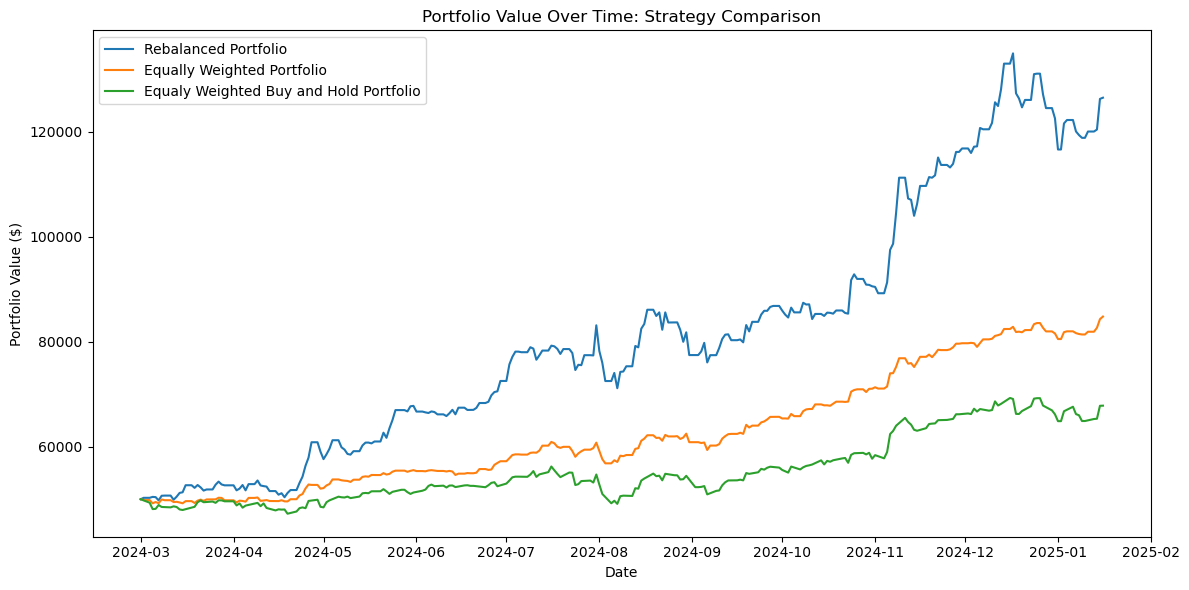


            FINAL PORTFOLIO VALUES
    Rebalanced Strategy     |  126452.72
    -----------------------------------------
    Equal Weight Strategy   |  84782.43
    -----------------------------------------
    Equal Weight Buy & Hold |  67816.12
    


In [36]:
# Define the starting and ending dates of training as testing period
strategy_params = StrategyParams(
    train_start_date='2021-01-01',#Change Accordingly
    train_end_date='2024-02-29',#Change Accordingly
    test_start_date='2024-03-01',#Change Accordingly
    test_end_date='2025-01-16'#Change Accordingly
)

#Stock Prices will be based on data on Yahoo Finance. Please change accordingly. 

# Set up the available trading strategies with its name.
trading_strategies: dict[str, TradingStrategy] = {
    'RSI': RsiStrategy(),
    'Linear Regression': LinearRegressionTradingStrategy(),
    'Random Forest': RandomForestTradingStrategy(),
    'Logistic Regression': LogisticRegressionTradingStrategy(),
    'MLP': MultilayerPerceptronTradingStrategy(),
    # Add your trading strategies here, dear Adrian.
}

# Set up your stock evaluator
stock_evaluator: StockEvaluator = StockEvaluator()
# Set up your portfolio rebalancer
rebalancer: PortfolioRebalancer = MaxExpectedReturnPortfolioRebalancer()

# Initialize the project manager
manager = GroupSixteenProjectManager(stock_evaluator, rebalancer)
# Run our project here
manager.run_group16_strategy(strategy_params, trading_strategies, save_trading_logs=True)